# CreateSimilarityMeasures
 - Use a CSV file and get information to plot data distributions to create local similarity measures

In [22]:
# Render our plots inline
%matplotlib inline

from requests import get
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math

from pandas.io.json import json_normalize


In [3]:
raw_data = pd.read_csv('./data/used_cars.csv')
raw_data

,caseID,Body,CCM,Car Code,Color,Doors,Gas,Manufacturer,Miles,Model,Power,Price,Speed,Year,ZIP
0,441_audi,sedan,2800,441,violet,4,gasoline,audi,29897,a6_2.8,193,49899,213,1995,8
1,108_audi,station_wagon,1600,108,turquoise,5,gasoline,audi,43858,a4_1.6,101,24699,183,1994,8
2,931_mercedes-benz,station_wagon,3200,931,gray,5,gasoline,mercedes-benz,32855,e_320,224,60799,241,1996,4
3,100_mercedes-benz,sedan,3000,100,yellow,4,diesel,mercedes-benz,18146,e_300_diesel,176,58499,224,1996,3
4,223_bmw,sedan,3500,223,dark_green,4,gasoline,bmw,24711,m3,320,73299,241,1997,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,700_bmw,station_wagon,2000,700,orange,5,gasoline,bmw,186068,520i,150,12099,183,1994,1
952,348_vw,fastback,1800,348,gray,2,gasoline,vw,70014,golf,100,16199,183,1995,3
953,331_mercedes-benz,sedan,2800,331,yellow,4,gasoline,mercedes-benz,21429,c_280,197,50199,213,1997,6
954,722_vw,fastback,1800,722,dark_red,2,gasoline,vw,25412,golf,100,17899,183,1994,2


In [39]:
def plot_numeric_box(plot_data, attribute, title):
    if(plot_data[attribute].min()>-100):
        ax = sns.boxplot(x=plot_data[attribute])
        #ax = sns.swarmplot(plot_data[attribute], color=".25")
        ax.set(xlabel=attribute, title=title + ' Boxplot (n='+ plot_data[[attribute]].dropna().__len__().__str__()+' (of ' + plot_data[[attribute]].__len__().__str__() +'))')
    
def plot_symbolic(plot_data, attribute, title):
    if(plot_data[attribute].isnull().sum() != plot_data.caseID.count()):
        ax = sns.countplot(x=attribute, data=plot_data)
        ax.set(xlabel=attribute, ylabel='Dist', title=title + ' Distribution (n='+ plot_data[[attribute]].dropna().__len__().__str__()+' (of ' + plot_data[[attribute]].__len__().__str__() +'))')
    

In [60]:
def get_ranges_numeric(df, attribute):
    a_min= df[[attribute]].min()[0]
    a_max= df[[attribute]].max()[0]
    q1 = df[[attribute]].quantile(0.25)[0]
    q3 = df[[attribute]].quantile(0.75)[0]
    
    return (a_min, a_max, q3-q1)

def get_ranges_symbolic(df, attribute):
    print('values for:', df.value_counts(attribute))
    
def similarity(x1, x2, max_diff, degree):
    diff = abs(x1 - x2)
    sim = 1 - (diff / max_diff) ** degree
    if sim < 0:
        sim = 0
    return sim

def find_polynomial(x, target_sim, max_diff):
    # Iterate through polynomial values until target similarity is reached
    for poly in np.arange(0.01, 100, 0.01):
        degree = 1/poly
        sim = similarity(0, x, max_diff, degree)
        if sim <= target_sim:
            return poly
    # If no polynomial results in target similarity, return None
    return None

def find_polynomial_position(max_diff, poly):
    # Define the parameters
    degree   = 1/poly
    # Define the x values to plot the similarity function for
    x = np.arange(0, max_diff+1)
    # Compute the similarity function values
    sim = [similarity(0, i, max_diff, degree) for i in x]
    # Find the position of the value closest to 0.3
    position = min(range(len(sim)), key=lambda i: abs(sim[i] - 0.3))
    
    return position, sim[position]

########## Plotting only

def plot_single_polynomial_fct(max_diff, poly):
    
    # Define the parameters
    pos, val = find_polynomial_position(max_diff, poly)
    degree   = 1/poly
    
    x = np.arange(0, max_diff+1)
    sim = [similarity(0, i, max_diff, degree) for i in x]
    
    # Plot the similarity function
    plt.plot(x, sim)
    
    
    plt.xlabel('Difference')
    plt.ylabel('Similarity')
    plt.title(f'Single Polynomial Similarity Function for poly={poly}')
    
    plt.scatter(pos, val, color='r')
    
    plt.show()


def plot_multiple_polynomial_fct(max_diff, max_poly):
    
    # Plot the similarity functions
    for poly in range(max_poly+1):
        x, sim = plot_polynomial_fct(max_diff, poly+1)
        plt.plot(x, sim, label=f'Poly {poly}')
    
    # Plot the markers for the minimum values
    for poly in range(max_poly+1):
        pos, val = find_polynomial_position(max_diff, poly+1)
        plt.scatter(pos, val, color='r')
    
    plt.xlabel('Difference')
    plt.ylabel('Similarity')
    plt.title(f'Multiple Polynomial Similarity Functions until poly={poly}')
    
    plt.legend()
    plt.show()
    
def plot_polynomial_fct(max_diff, poly):
    
    # Define the parameters
    pos, val = find_polynomial_position(max_diff, poly)
    degree   = 1/poly
    
    x = np.arange(0, max_diff+1)
    sim = [similarity(0, i, max_diff, degree) for i in x]
    
    return x, sim

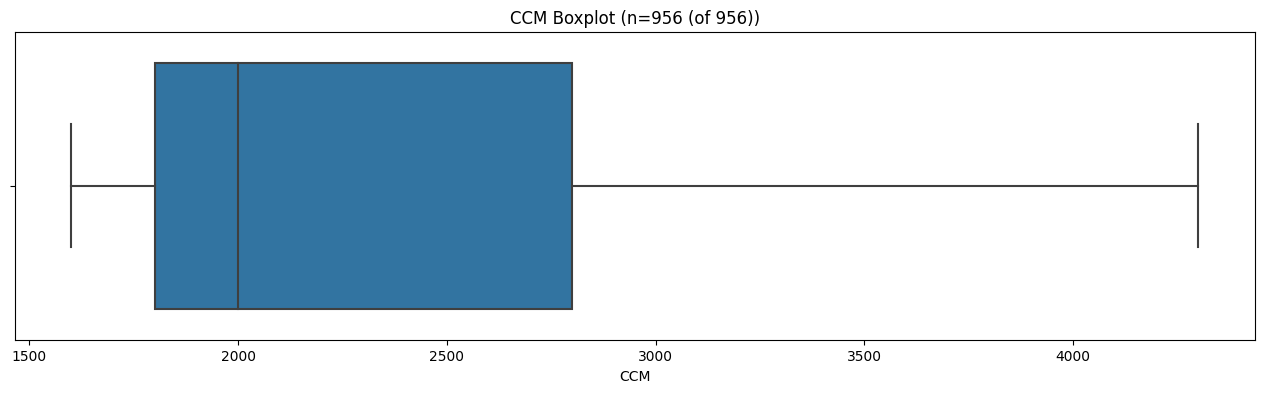

In [77]:
att_name = 'CCM'

plt.rcParams["figure.figsize"] = (16, 4)
plot_numeric_box(raw_data, att_name, att_name)

## Determine the polynomial for an attribute

In [78]:
att_min, att_max, sim_03 = get_ranges_numeric(raw_data, att_name)

    
print('min-max:         [{},{}]'.format(att_min, att_max))
print('0.3 sim (q3-q1):', sim_03)

min-max:         [1600,4300]
0.3 sim (q3-q1): 1000.0


In [79]:
sim_target = 0.3 # similarity score used as threshold
x_target = sim_03 # 
max_difference = att_max - att_min # the maximum difference between the attribute values in the dataset

poly = find_polynomial(x_target, sim_target, max_difference)
print(f"For x={x_target}, the smallest polynomial with similarity > 0.3: {poly}")

For x=1000.0, the smallest polynomial with similarity > 0.3: 2.79


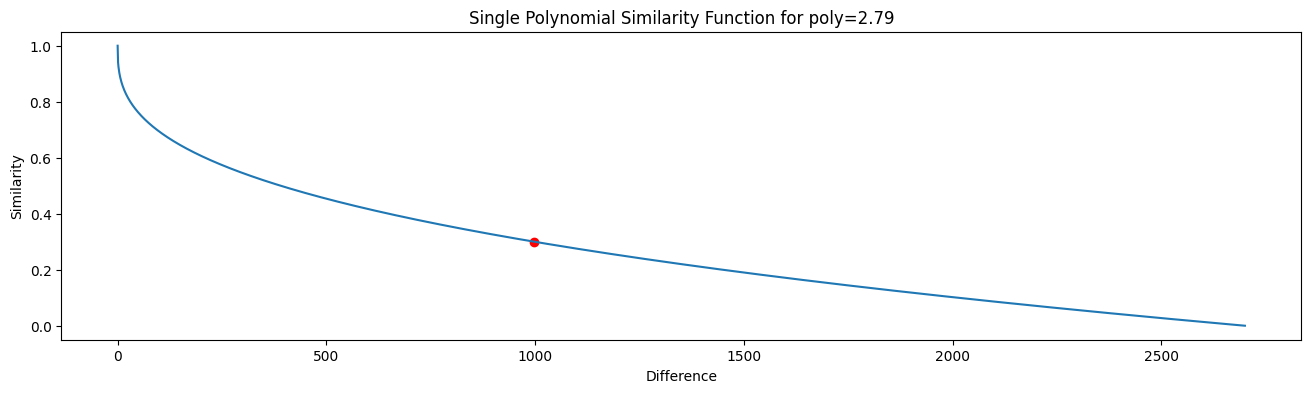

In [80]:
plot_single_polynomial_fct(max_difference, poly)

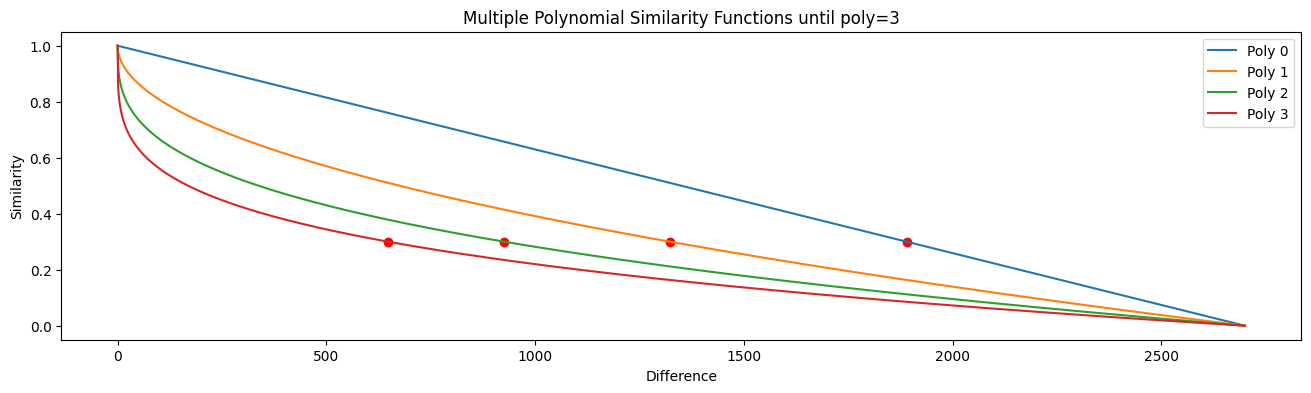

In [81]:
plot_multiple_polynomial_fct(max_difference, math.ceil(poly))

## Generate the polynomials for all numeric attributes 

In [84]:
# columns that can be calculated
numeric_columns = ['CCM', 'Doors', 'Miles', 'Power', 'Price', 'Speed', 'Year', 'ZIP']

for col in numeric_columns:
    att_min, att_max, sim_03 = get_ranges_numeric(raw_data, col)
    poly = find_polynomial(sim_03, 0.3, att_max - att_min)
    print(f"For attribute {col} the target x is {sim_03} (min,max=[{att_min},{att_max}]), the smallest polynomial with similarity > 0.3 is: {poly}")

For attribute CCM the target x is 1000.0 (min,max=[1600,4300]), the smallest polynomial with similarity > 0.3 is: 2.79
For attribute Doors the target x is 3.0 (min,max=[2,5]), the smallest polynomial with similarity > 0.3 is: 0.01
For attribute Miles the target x is 71433.5 (min,max=[1621,215968]), the smallest polynomial with similarity > 0.3 is: 3.09
For attribute Power the target x is 75.0 (min,max=[60,320]), the smallest polynomial with similarity > 0.3 is: 3.4899999999999998
For attribute Price the target x is 19525.0 (min,max=[4799,95199]), the smallest polynomial with similarity > 0.3 is: 4.3
For attribute Speed the target x is 30.0 (min,max=[173,252]), the smallest polynomial with similarity > 0.3 is: 2.7199999999999998
For attribute Year the target x is 1.0 (min,max=[1994,1997]), the smallest polynomial with similarity > 0.3 is: 3.09
For attribute ZIP the target x is 5.0 (min,max=[0,9]), the smallest polynomial with similarity > 0.3 is: 1.6500000000000001


## Symbolic Attributes

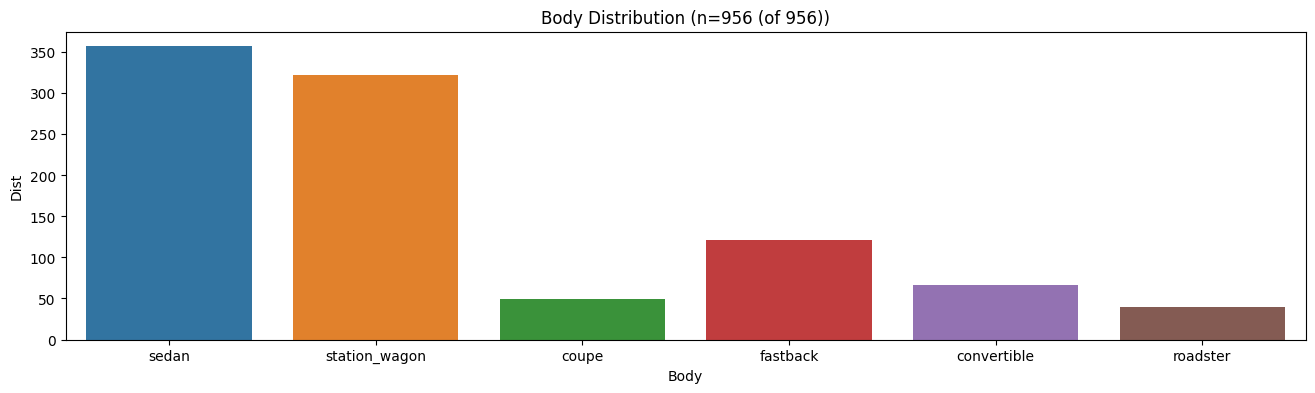

In [85]:
plot_symbolic(raw_data, 'Body', 'Body')

In [86]:
get_ranges_symbolic(raw_data, 'Body')

values for: Body
sedan            357
station_wagon    322
fastback         121
convertible       67
coupe             49
roadster          40
dtype: int64
